In [374]:
import os
import glob
import numpy as np
import itertools
import random
import multiprocessing
from multiprocessing.dummy import Pool
import pandas as pd
import datetime

from skimage import feature
from PIL import Image, ImageOps
import pywt
import matplotlib.pyplot as plt

from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import moment

from skimage.restoration import denoise_wavelet
%matplotlib inline

In [375]:
path2train = 'data/train/'
path2test = 'data/test'

In [376]:
img_width = img_height=256

In [377]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [378]:
def preProcessing(img, row=0, col=0, center=True):
    
    '''img = resizeImage(img) # cant resize the image!!
    img = RGB2Gray(img) #cant transform to rgb!'''
    
    if center:
        img = crop_image_center(img)
    else:
        img = crop_image_corners(img, row=row, col=col)

    img = localBinaryPatterns(img)
    #img = img - filter_median(img)
    #img = img - filter_wavelet(img)
    img = noise_wavelet(img)
    #img = vectorizeImage(img, nb_channels=3)
    return img

In [379]:
def crop_image_corners(img, row, col, img_width=128, img_height=128):

    width, height = img.size   # Get dimensions

    x = row*(width-img_width)
    y = col*(height-img_height)
    crop = img.crop((x, y, x + img_width, y + img_height))
    
    return crop

In [380]:
def crop_image_center(img, img_width=128, img_height=128):
    width, height = img.size   # Get dimensions

    left = (width - img_width)/2
    top = (height - img_height)/2
    right = (width + img_width)/2
    bottom = (height + img_height)/2

    crop = img.crop((left, top, right, bottom))
    return crop

In [381]:
def RandomCropImage(img, img_width=128, img_height=128):
    
    width, height = img.size   # Get dimensions

    idx_width = random.randint(0, width - img_width)
    idx_height = random.randint(0, height - img_height)

    return img.crop((idx_width, idx_height, idx_width+img_width, idx_height + img_height))

In [382]:
def vectorizeImage(img, img_width=128, img_height=128, nb_channels = 1):
    return img.reshape(-1,img_width * img_height * nb_channels)

In [383]:
def filter_median(img, factor=2):
    return ndimage.median_filter(img, factor)

In [384]:
def filter_wavelet(img):
    return denoise_wavelet(img=img, multichannel=True)

In [385]:
def resizeImage(img, img_width=128, img_height=128):
    img = img.resize((img_width, img_height))
    return np.array(img)

In [386]:
def localBinaryPatterns(img, numPoints=24, radius=2):
    
    img_lbp = np.zeros(np.array(img).shape)
    for i in range(np.array(img).shape[2]):
        img_lbp[:,:,i] = feature.local_binary_pattern(img.getchannel(i), numPoints,
                    radius, method="uniform")
    return img_lbp

In [387]:
def noise_wavelet(img, n_moments=9):
    
    res = []
    for i in range(0, img.shape[2]):
        coeffs = pywt.dwt2(img[:,:,i], wavelet='haar')
        cA, (cH, cV, cD) = coeffs

        for j in range(0, n_moments):
            res.append(moment(cH.ravel(), moment=j))
            res.append(moment(cV.ravel(), moment=j))
            res.append(moment(cD.ravel(), moment=j))
    return res

In [388]:
def RGB2Gray(img):
    img = np.array(img)
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [389]:
def extractImage(path, row=0, col=0, center=True, isTrain = True):

    with Image.open(path) as img:
        img = preProcessing(img, row, col, center)
    if isTrain:
        target = path.split('/')[-2]
    else:
        target = path.split('/')[-1]
    return img, target

In [390]:
def extractImage_helper(args):
    return extractImage(*args)

In [391]:
def extractImagesParallel(path_lst, row=0, col=0, center=True, isTrain=True, threads=2):
    pool = Pool(threads)
    #imgs, targets = zip(*pool.map(extractImage, path))
    #result = pool.map(extractImage, path_lst)
    job_args = [(path, row, col, center, isTrain) for path in path_lst] 
    result = pool.map(extractImage_helper, job_args)
    pool.close()
    pool.join()
    return result

In [392]:
def get_data(path, row=0, col=0, center=True, nb_threads=2, format_file = '*.jpg', isTrain = True):
    results = []

    for subdir, dirs, files in os.walk(path):
        if subdir.split('/')[-1] != '':

            print('Reading files from dir: {}'.format(subdir))

            path_folder = os.path.join(subdir, format_file)
            filesPath = glob.glob(path_folder) 

            res  = extractImagesParallel(filesPath, row, col, center, isTrain, threads=nb_threads)
            results.append(res)
    
    flattened_list = [y for x in results for y in x]
    X, y = map(list, zip(*flattened_list))

    X = np.array(X)
    y = np.array(y)
    
    if np.array(X).shape[1] == 1:
        X = np.squeeze(X, axis=1)
    
    return X, y

In [393]:
crop_borders = True

In [394]:
print('Crop borders: {}'.format(crop_borders))

if crop_borders:

    params = {'center': {
                'row': 0, 'col': 0, 'center': True
                },
              'rb': {
                'row': 1, 'col': 0, 'center': False
                },
              'lb': {
                'row': 0, 'col': 0, 'center': False
                },
              'rh': {
                'row': 0, 'col': 1, 'center': False
                },
              'lh': {
                'row': 1, 'col': 1, 'center': False
                }
             }
else:
    
    params = {'center': {
                'row': 0, 'col': 0, 'center': True
                }
             }

Crop borders: True


In [ ]:
X_dict = {}
y_dict = {}

X_test_dict = {}
fname_test_dict = {}

for k, v in params.items():
    params_lst = []
    for k1, v1 in v.items():
        params_lst.append(v1)
    
    print('\nReading training data for {} image...\n'.format(k))
    X_dict[k], y_dict[k] = get_data(path2train, row=params_lst[0], col=params_lst[1],
                                        center=params_lst[2], nb_threads=cpu_count)
    
    print('\nReading testing data for {} image...\n'.format(k))
    X_test_dict[k], fname_test_dict[k] = get_data(path2test,  row=params_lst[0], col=params_lst[1],
                                        center=params_lst[2], nb_threads=cpu_count, format_file='*.tif', isTrain=False)


Reading training data for center image...

Reading files from dir: data/train/iPhone-4s
Reading files from dir: data/train/Motorola-Droid-Maxx
Reading files from dir: data/train/HTC-1-M7
Reading files from dir: data/train/Samsung-Galaxy-S4
Reading files from dir: data/train/Motorola-X
Reading files from dir: data/train/Motorola-Nexus-6
Reading files from dir: data/train/LG-Nexus-5x
Reading files from dir: data/train/Samsung-Galaxy-Note3
Reading files from dir: data/train/iPhone-6
Reading files from dir: data/train/Sony-NEX-7

Reading testing data for center image...

Reading files from dir: data/test

Reading training data for rb image...

Reading files from dir: data/train/iPhone-4s
Reading files from dir: data/train/Motorola-Droid-Maxx
Reading files from dir: data/train/HTC-1-M7
Reading files from dir: data/train/Samsung-Galaxy-S4
Reading files from dir: data/train/Motorola-X
Reading files from dir: data/train/Motorola-Nexus-6
Reading files from dir: data/train/LG-Nexus-5x
Reading f

### Normalization

In [ ]:
normalization_type = 'zScore'

In [ ]:
print('Normalization type: {}'.format(normalization_type))

if normalization_type == 'minMax':
    scaler = MinMaxScaler()
    
elif normalization_type == 'zScore':        
    scaler =  StandardScaler()

### Calculate for each image patch

In [ ]:
X_train_dict = {}
X_valid_dict = {}
y_train_dict = {}
y_valid_dict = {}

In [ ]:
X_test_dict.keys()

In [ ]:
test_size = 0.2

for k in params.keys():
    X_train_dict[k], X_valid_dict[k], y_train_dict[k], y_valid_dict[k] = train_test_split(X_dict[k], y_dict[k], test_size=test_size, random_state=42)
    
    ## data normalization
    X_train_dict[k] = scaler.fit_transform(X_train_dict[k])
    X_valid_dict[k] = scaler.transform(X_valid_dict[k])
    X_test_dict[k] = scaler.transform(X_test_dict[k])

In [ ]:
print('Shape of the training data X: {}, y: {}'.format(X_train_dict['center'].shape, y_train_dict['center'].shape))
print('Shape of the valid data X: {}, y: {}'.format(X_valid_dict['center'].shape, y_valid_dict['center'].shape))

# Model

### Logistic Regression

In [358]:
lr_model = linear_model.LogisticRegression(max_iter=10)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_valid)

In [359]:
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(lr_model.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on valid set: {:.2f}'.format(lr_model.score(X_valid, y_valid)))

Accuracy of logistic regression classifier on train set: 0.64
Accuracy of logistic regression classifier on valid set: 0.60


### Neural Network

In [360]:
mlp_model = MLPClassifier(hidden_layer_sizes=(512,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, tol=1e-4, random_state=1,
                    learning_rate_init=.1, activation='relu')
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_valid)

In [361]:
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(mlp_model.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on valid set: {:.2f}'.format(mlp_model.score(X_valid, y_valid)))

Accuracy of logistic regression classifier on train set: 0.93
Accuracy of logistic regression classifier on valid set: 0.64


In [362]:
cm_lr = confusion_matrix(y_valid, y_pred_lr)
cm_mlp = confusion_matrix(y_valid, y_pred_mlp)

#http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html

In [363]:
def plot_cm(cm, title='Confusion matrix', cmap=None, normalize=True):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.title(title)

Normalized confusion matrix
Normalized confusion matrix


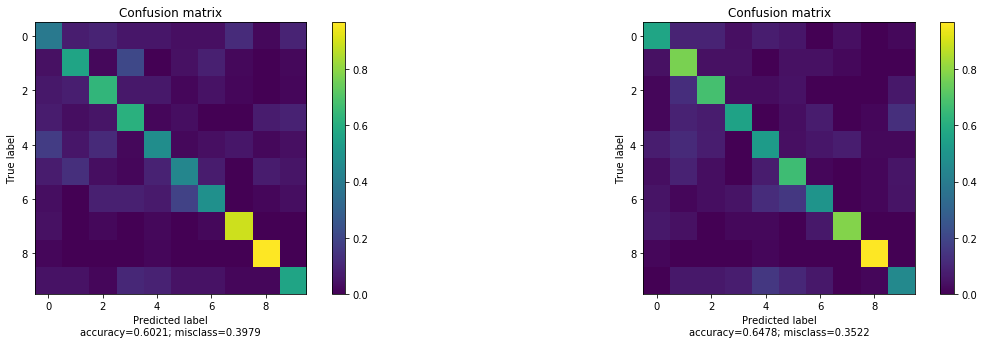

In [364]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plot_cm(cm_lr)

plt.subplot(1,2,2)
plot_cm(cm_mlp)

In [365]:
def generate_submission_file(fname, predictions, info='cama_model'):
    
    now = datetime.datetime.now()
    
    submission_df = pd.DataFrame()
    submission_df['fname'] = fname
    submission_df['camera'] = [x for x in predictions]
    
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    submission_df.to_csv(sub_file, index=False)
    print('done!')

In [366]:
y_pred_test_mlp = mlp_model.predict(X_test)
y_pred_test_lr = lr_model.predict(X_test)

In [369]:
generate_submission_file(filename_test, y_pred_test_mlp)

done!


In [ ]:
def showCamaraTransformations():

    plt.figure(figsize=(20,5))
    path = 'data/train/iPhone-4s/(iP4s)9.jpg'
    with Image.open(path) as img:
        plt.subplot(1,3,1)
        img = RGB2Gray(img)
        img_wav = denoise_wavelet(img)
        plt.imshow(np.round(img-img_wav), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,2)
        img_mean = median_filter(img, factor=4)
        plt.imshow(np.round(img-img_mean), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,3)
        img_lbp = localBinaryPatterns(img)
        plt.imshow(img_lbp, cmap='gray')
        plt.axis('off')
        
#showCamaraTransformations()

In [ ]:
'''
path = 'data/train/iPhone-4s/(iP4s)9.jpg'
with Image.open(path) as img:
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
print('cA {}'.format(cA.shape) )
print('cH: {}'.format(cH.shape) )
print('cV: {}'.format(cV.shape) )
print('cD: {}'.format(cD.shape) )
'''

In [ ]:
'''path = 'data/train/iPhone-4s/(iP4s)9.jpg'
img = Image.open(path)
plt.imshow(crop_image_corners(img, row=1, col=0))'''

In [ ]:
print(np.array(X).shape)
img_wav_filtered = denoise_wavelet(X, multichannel=True, convert2ycbcr=True,  mode='soft')

### Wavelet

In [ ]:
'''
import glob, os
folder = 'data/train/Sony-NEX-7'
for filename in glob.iglob(os.path.join(folder, '*.JPG')):
    os.rename(filename, filename[:-4] + '.jpg')
'''

In [ ]:
def showCamaraPhotos(X, y=[], is_train =True, img_width=128, img_height=128, nb_channels = 1):

    idx = random.randint(0,len(X))
    if is_train:
        plt.title(y[idx])
    img = X[idx].reshape(img_width, img_height, nb_channels)
    if nb_channels == 1:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    
plt.figure(figsize=(20,5))
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    showCamaraPhotos(X, y, nb_channels=3)